# Image Recognition via Vietoris-Rips Complex

In [1]:
import numpy as np
from scipy.sparse import csr_matrix, csgraph
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

In [2]:
def calc_index(k, i, j):
    """Calculate index of a vertice: g(v_{k,i,j}) = (k + 1) * i + j + sum_{l=0}^{k} l^2

    Args:
        k (int): Length of the side of the square. -1!
        i (int): Row index of left top the square in a image.
        j (int): Column index of left top the square in a image.

    Returns:
        int: The index of the vertice.
    """    
    index = (k + 1) * i + j + np.array([l**2 for l in range(k+1)]).sum()
    return index

def get_vertice(image, k, i, j):
    """Get a square (a vertice in the graph) from a given image.
       v_{k,i,j} = [N, N - k, i] * [N, N - k, j] in V_{N, N}

    Args:
        image (np.array): N * N gray scale image.
        k (int): Length of the side of the square.
        i (int): Row index of left top the square in a image.
        j (int): Column index of left top the square in a image.

    Returns:
        np.array: A k * k gray scale sub-image.
    """    
    square_width = image.shape[0] - k
    vertice = image[i:(i + square_width), j:(j + square_width)]
    return vertice

def calc_weight(vertice_1, vertice_2):
    """Calculate the weight of the edge between two given vertices.
       w_f({v_1, v_2}) = |#f(v_2) = #f(v_1)|, where #f(v) is the number of colors of v.

    Args:
        vertice_1 (np.array[int]): A gray scale sub-image (vertice 1).
        vertice_2 (np.array[int]): A gray scale sub-image (vertice 2).

    Returns:
        int: Weight of the edge.
    """    
    weight = abs(np.unique(vertice_1).size - np.unique(vertice_2).size)
    return weight

# def assign_values_to_list(k, i, j, vertices_from_list, vertices_to_list, weights_list, image):
#     vertices_from_list.append(calc_index(k, i, j))
#     vertices_to_list.append(calc_index(k + 1, i, j))
#     weights_list.append(calc_weight(get_vertice(image, k, i, j), get_vertice(image, k + 1, i, j)))

## Construction of the 1-Skelton of the Vietoris-Rips Complex Using All Squares

In [3]:
def construct_one_skelton(image, small_epsilon=0.0):
    """Construct 1-skelton of the Vietoris-Rips Complex using all squares of a image.

    Args:
        image (np.array): N * N gray scale image.
        small_epsilon (float, optional): Small constant. If weights are under this values, weights will be 1 else be 0.

    Returns:
        Tuple[List, List, List]: V_from (Index list of vertices), V_to (Index list of vertices), tilde{W} (Binarized weight list)
    """    
    image_size = image.shape[0]
    vertices_from_list = []
    vertices_to_list = []
    weights_list = []
    weights_tilde_list = []

    for k in tqdm(range(image_size -1)):
        for i in range(k + 1):
            for j in range(k + 1):
                index_k_i_j = calc_index(k, i, j)

                vertices_from_list.append(index_k_i_j)
                vertices_to_list.append(calc_index(k + 1, i, j))
                weights_list.append(calc_weight(get_vertice(image, k, i, j), get_vertice(image, k + 1, i, j)))

                # TODO: 関数化
                vertices_from_list.append(index_k_i_j)
                vertices_to_list.append(calc_index(k + 1, i, j + 1))
                weights_list.append(calc_weight(get_vertice(image, k, i, j), get_vertice(image, k + 1, i, j + 1)))

                vertices_from_list.append(index_k_i_j)
                vertices_to_list.append(calc_index(k + 1, i + 1, j))
                weights_list.append(calc_weight(get_vertice(image, k, i, j), get_vertice(image, k + 1, i + 1, j)))

                vertices_from_list.append(index_k_i_j)
                vertices_to_list.append(calc_index(k + 1, i + 1, j + 1))
                weights_list.append(calc_weight(get_vertice(image, k, i, j), get_vertice(image, k + 1, i + 1, j + 1)))  

    for weight in weights_list:
        if weight > small_epsilon:
            weights_tilde_list.append(0)
        else:
            weights_tilde_list.append(1)

    return vertices_from_list, vertices_to_list, weights_tilde_list

## Highlighting Minimal Size Squares

In [4]:
IMAGE_ADDRESS = 'img/tea.png'
IMAGE_RESIZE = (10, 10)

pil_image = Image.open(IMAGE_ADDRESS)
pil_image = pil_image.resize(IMAGE_RESIZE).convert('L')
image = np.array(pil_image)

In [5]:
"""
Calculate minimal size squares and run object detection based on the result.
"""
vertices_from_list, vertices_to_list, weights_tilde_list = construct_one_skelton(image, small_epsilon=0)

# 縦がV_from、横がV_toで重みがW_tildeとなるグラフをCSR形式で作る
compressed_sparse_matrix = csr_matrix((weights_tilde_list, (vertices_from_list, vertices_to_list)), shape = (max(vertices_to_list) + 1, max(vertices_to_list) + 1))
connected_components = csgraph.connected_components(compressed_sparse_matrix)[1]

vertice_tmp = 0
for index, connected_component in enumerate(connected_components):
    if connected_component == 0:
        vertice_tmp = index

N = image.shape[0]
vector = np.array([l**2 for l in range(N + 1)])
k_prime = N - [l for l in range(1,N+1) if vector[:l+1].sum() > vertice_tmp][0]
detection_result = np.zeros_like(image)
for i in tqdm(range(k_prime + 1)):
    for j in range(k_prime + 1):
        if connected_components[calc_index(k_prime, i, j)] == 0:
            detection_result[i:(i + detection_result.shape[0] - k_prime), j:(j + detection_result.shape[1] - k_prime)] = get_vertice(image, k_prime, i, j)


100%|██████████| 1/1 [00:00<00:00, 7639.90it/s]


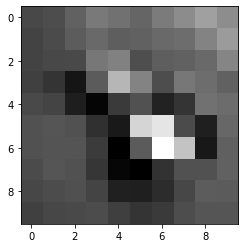

In [6]:
plt.imshow(detection_result, cmap = "gray")
plt.show()